# Time series
## Problem
1. Descrever a série temporal de acordo com as suas propriedades e componentes. Isto inclui a tendência, sazonalidade, estacionariedade, entre outros.
1. Descrever a estrutura do modelo ARIMA que melhor se ajusta aos dados.
1. Avaliar o desempenho de um modelo de regressão com validação cruzada
1. Seguindo o ponto 3.: Descrever o impacto dos seguintes aspectos no desempenho:
    1. Diferentes horizontes temporais;
    1. Desempenho nos valores extremos da série;
    1. Comparação de diferentes algoritmos de regressão.

    # Data Source
[Git repo](https://github.com/vcerqueira/energy_load_data)

# Importing libraries

In [1]:
# import libraries for plotting
import matplotlib.pyplot as plt
# import libraries for data manipulation
import pandas as pd  # Series and DataFrames
# import libraries for machine learning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setting up the environment

In [2]:
# define the path to the data
data_source = "https://storage.googleapis.com/nuclio_data/ml/energy_load_pt.csv"

# Importing data

In [12]:
# Read data
# %%time
df = pd.read_csv(data_source)
df.head(5)

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0


In [13]:
df.tail(5)

,datetime,load
13099,2022-05-17 04:00:00,5190.0
13100,2022-05-17 05:00:00,5297.0
13101,2022-05-17 06:00:00,5441.0
13102,2022-05-17 07:00:00,5735.0
13103,2022-05-17 08:00:00,5418.0


In [14]:
df.shape

(13104, 2)

In [15]:
df.dtypes

datetime     object
load        float64
dtype: object

In [16]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [17]:
df

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0
...,...,...
13099,2022-05-17 04:00:00,5190.0
13100,2022-05-17 05:00:00,5297.0
13101,2022-05-17 06:00:00,5441.0
13102,2022-05-17 07:00:00,5735.0


In [18]:
df_day = df.resample('D', on='datetime').mean()

In [21]:
df_day["load"] = df_day["load"].round(2)

In [22]:
df_day.head(5)

,load
datetime,
2020-11-17,4294.69
2020-11-18,5373.12
2020-11-19,6329.00
2020-11-20,6538.71
2020-11-21,6666.21


In [23]:
df_day.shape

(547, 1)

In [24]:
df_day.tail(5)

,load
datetime,
2022-05-13,5763.75
2022-05-14,5791.00
2022-05-15,5750.46
2022-05-16,5365.79
2022-05-17,5323.11


In [25]:
dates = pd.date_range('2020-11-17', '2022-05-17')

In [26]:
dates.shape

(547,)

In [27]:
len(dates)

547

In [28]:
df_day.select_dtypes(include=['number']).isnull().sum()

load    0
dtype: int64

In [30]:
df_day.isnull().sort_values(by='load', ascending=False)

,load
datetime,
2020-11-17,False
2021-11-19,False
2021-11-13,False
2021-11-14,False
2021-11-15,False
...,...
2021-05-12,False
2021-05-11,False
2021-05-10,False


In [31]:
df_day.select_dtypes(include=['object']).isnull().sum()

Series([], dtype: float64)

# Time Series Decomposition
## Observed, Seasonal, Trend and Residual

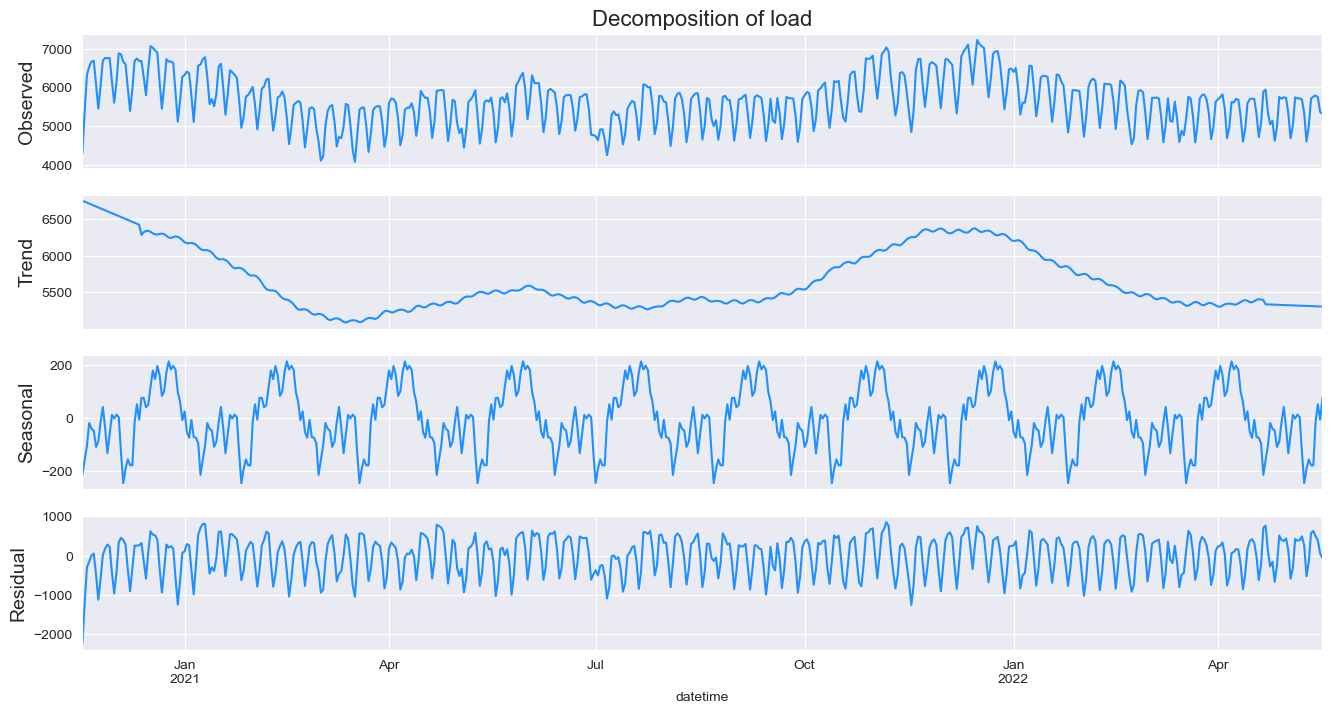

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex='all', figsize=(16, 8))
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns = [
    'load'
]
for column in core_columns:
    res = seasonal_decompose(df_day[column], period=52, model='additive', extrapolate_trend='freq')
    ax[0].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
    ax[0].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
    ax[1].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
    ax[2].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
    ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

In [33]:
df_day.head()

,load
datetime,
2020-11-17,4294.69
2020-11-18,5373.12
2020-11-19,6329.00
2020-11-20,6538.71
2020-11-21,6666.21


In [34]:
ndata = df_day.shift(1)
ndata.head()

,load
datetime,
2020-11-17,NaN
2020-11-18,4294.69
2020-11-19,5373.12
2020-11-20,6329.00
2020-11-21,6538.71


In [35]:
data_base = pd.concat([df_day, ndata], axis=1)
data_base[:10]

,load,load
datetime,,
2020-11-17,4294.69,NaN
2020-11-18,5373.12,4294.69
2020-11-19,6329.00,5373.12
2020-11-20,6538.71,6329.00
2020-11-21,6666.21,6538.71
2020-11-22,6692.58,6666.21
2020-11-23,6088.67,6692.58
2020-11-24,5452.25,6088.67
2020-11-25,6040.29,5452.25


In [36]:
data_base.columns = ['Actual_Value', 'Forcaste_Value']

In [37]:
data_base.head()

,Actual_Value,Forcaste_Value
datetime,,
2020-11-17,4294.69,NaN
2020-11-18,5373.12,4294.69
2020-11-19,6329.00,5373.12
2020-11-20,6538.71,6329.00
2020-11-21,6666.21,6538.71


In [38]:
data_base.iloc[:, :2]

,Actual_Value,Forcaste_Value
datetime,,
2020-11-17,4294.69,NaN
2020-11-18,5373.12,4294.69
2020-11-19,6329.00,5373.12
2020-11-20,6538.71,6329.00
2020-11-21,6666.21,6538.71
...,...,...
2022-05-13,5763.75,5713.21
2022-05-14,5791.00,5763.75
2022-05-15,5750.46,5791.00


In [39]:
data_base.dropna(inplace=True)
data_base.head()

,Actual_Value,Forcaste_Value
datetime,,
2020-11-18,5373.12,4294.69
2020-11-19,6329.00,5373.12
2020-11-20,6538.71,6329.00
2020-11-21,6666.21,6538.71
2020-11-22,6692.58,6666.21


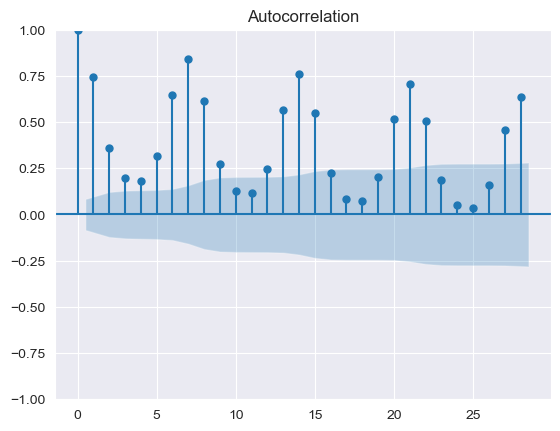

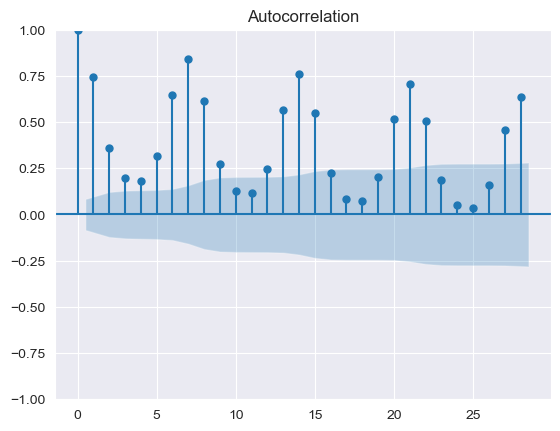

In [40]:
plot_acf(df_day)

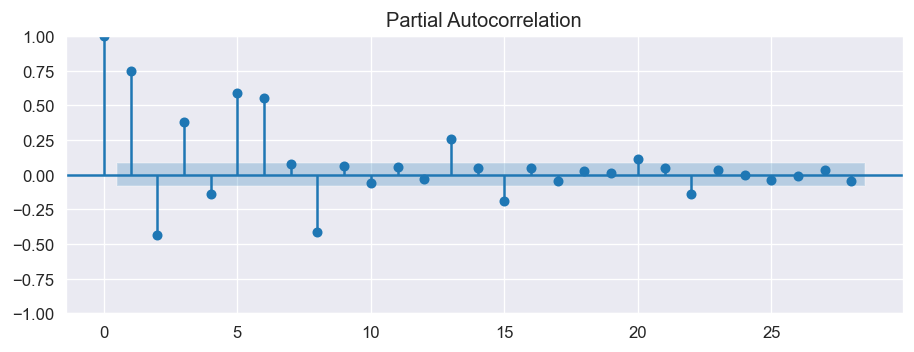

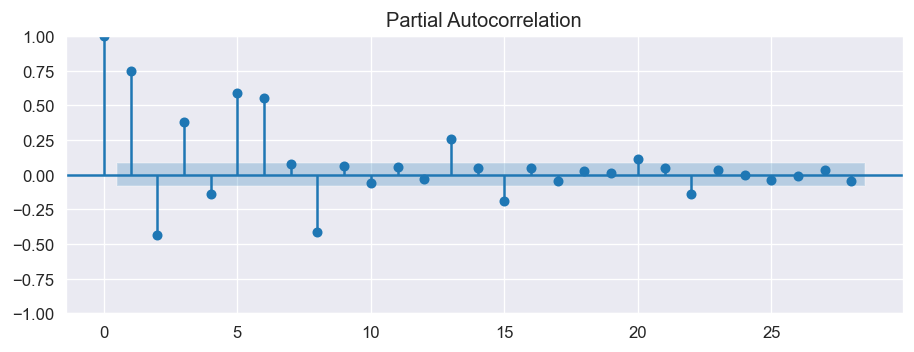

In [106]:
plot_pacf(df_day, method='ywm')

## Arima

In [42]:
from statsmodels.tsa.arima.model import ARIMA

## Order of AR

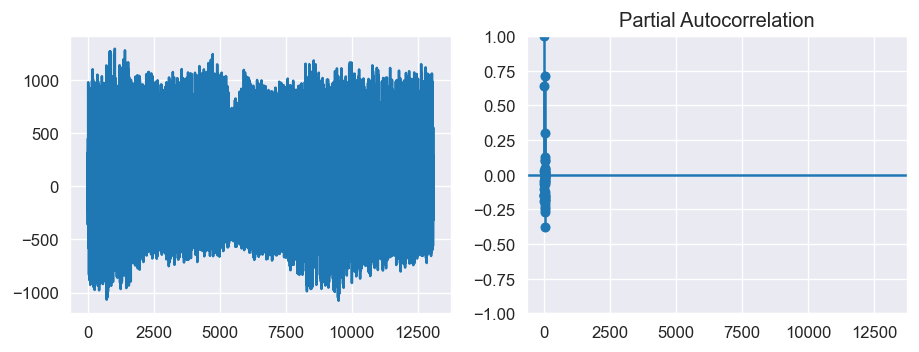

In [117]:
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})
fig, axes = plt.subplots(1, 2, sharex='all')
axes[0].plot(df.load.diff())
axes[1].set(ylim=(0, 5))
plot_pacf(df.load.diff().dropna(), ax=axes[1], method='ywm')
plt.show()

## Order of MA

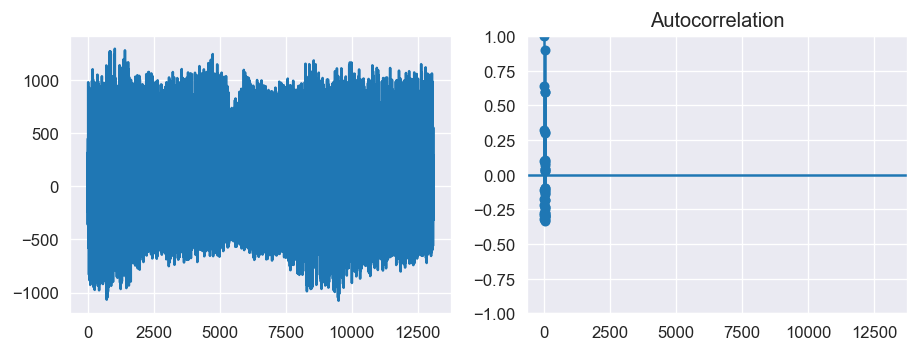

In [118]:
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})
fig, axes = plt.subplots(1, 2, sharex='all')
axes[0].plot(df.load.diff())
axes[1].set(ylim=(0, 1.2))
plot_acf(df.load.diff().dropna(), ax=axes[1])
plt.show()

In [119]:
data_train = df_day[1:410]
data_test = df_day[410:547]

In [144]:
def arima_forecast_plot(train, test, order):
    model = ARIMA(train, order=order)
    results = model.fit()
    pred = results.forecast(len(test))
    plt.figure(figsize=(10, 5))
    plt.plot(data_test, color='green')
    plt.plot(data_train, color='blue')
    plt.plot(pred, color='red')
    return results

In [149]:
def arima_residual_plot(results):
    residuals = pd.DataFrame(results.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

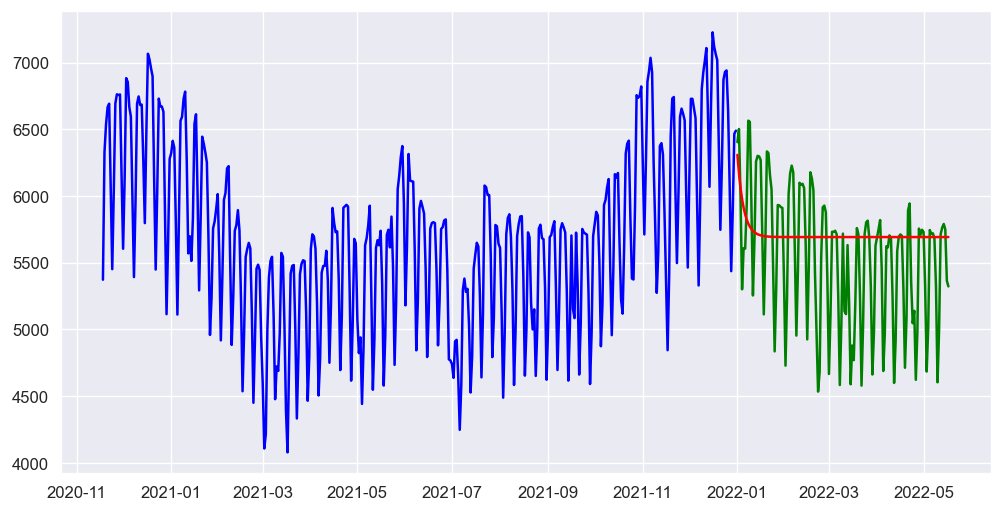

In [145]:
result = arima_forecast_plot(data_train, data_test, (1, 0, 0))

In [147]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:23:31   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

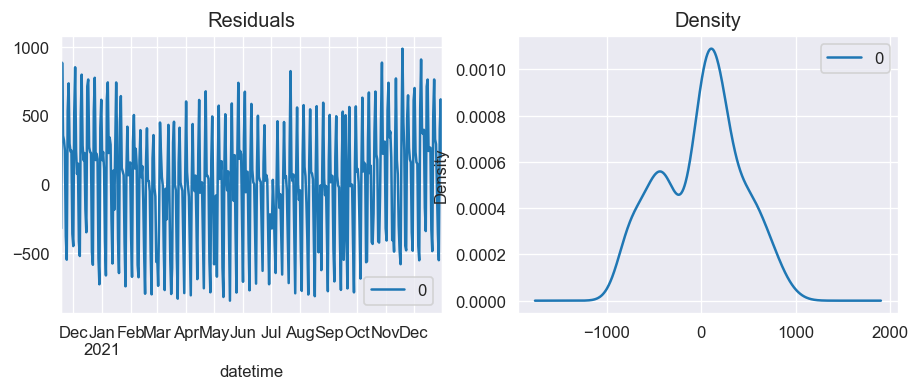

In [150]:
arima_residual_plot(result)

/Users/fernandosedrez/.pyenv/versions/anaconda3-2023.03-1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


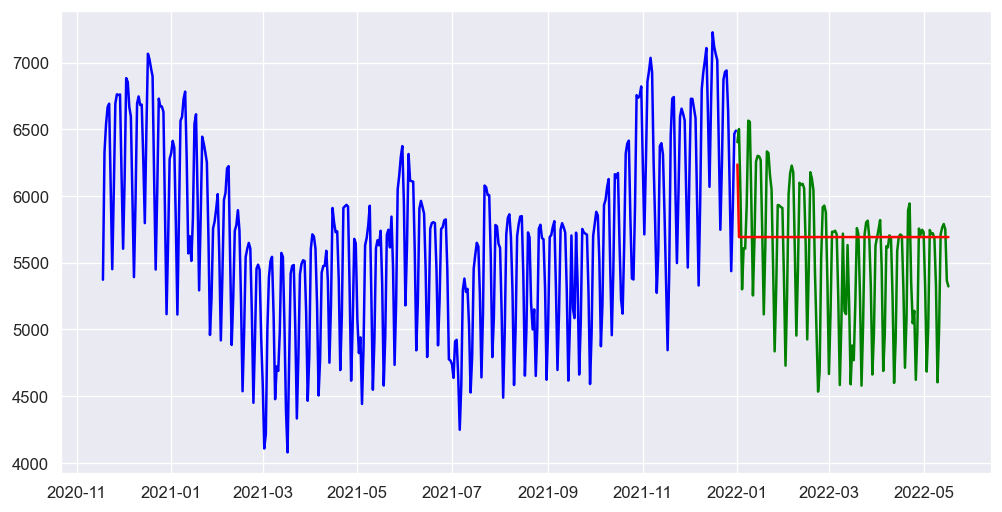

In [151]:
arima_forecast_plot(data_train, data_test, (0, 0, 1))

In [152]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:25:23   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

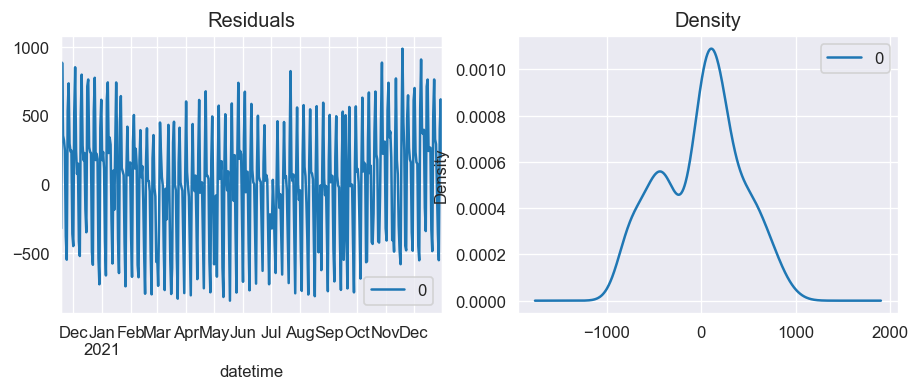

In [153]:
arima_residual_plot(result)

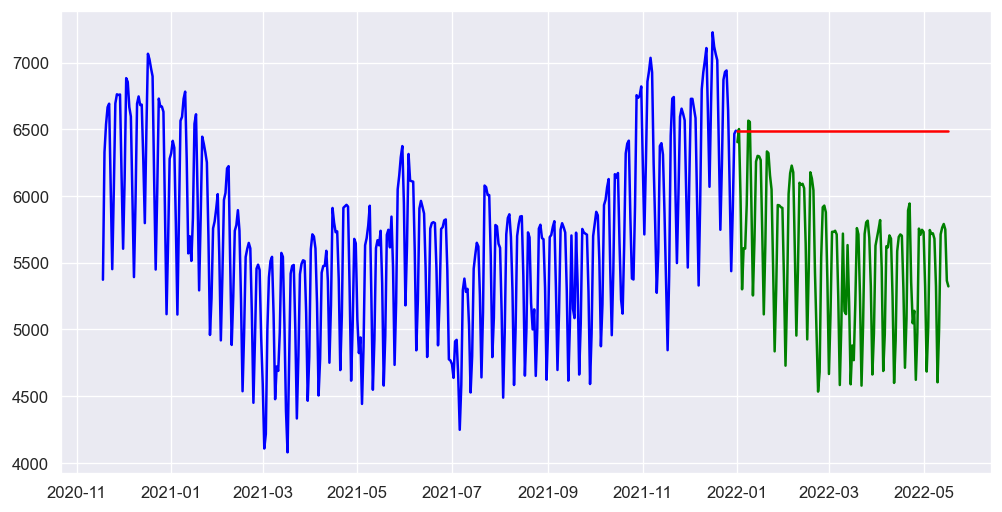

In [154]:
arima_forecast_plot(data_train, data_test, (0, 1, 0))

In [155]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:25:30   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

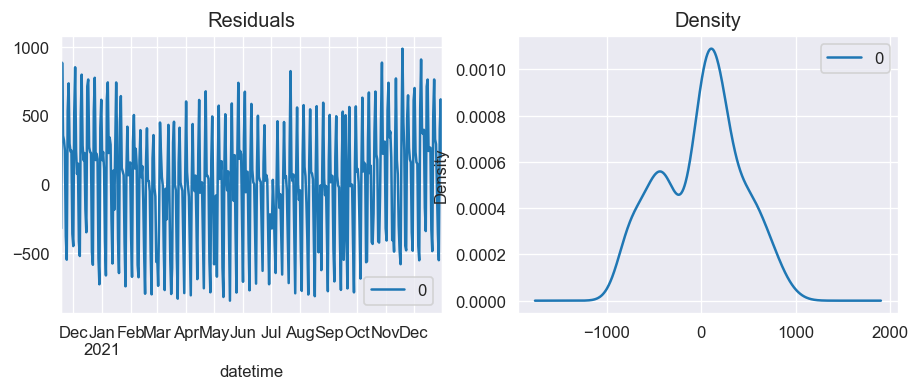

In [156]:
arima_residual_plot(result)

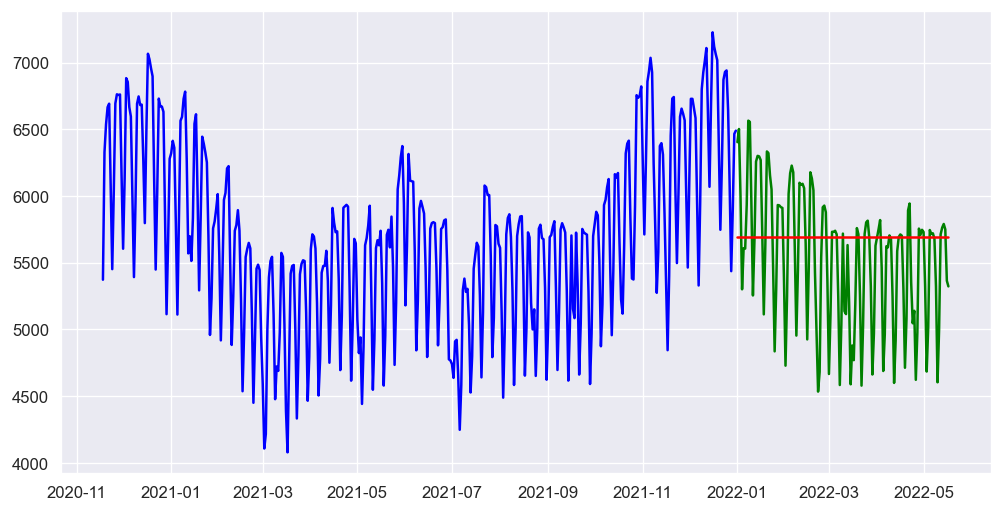

In [157]:
arima_forecast_plot(data_train, data_test, (0, 0, 0))

In [158]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:25:52   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

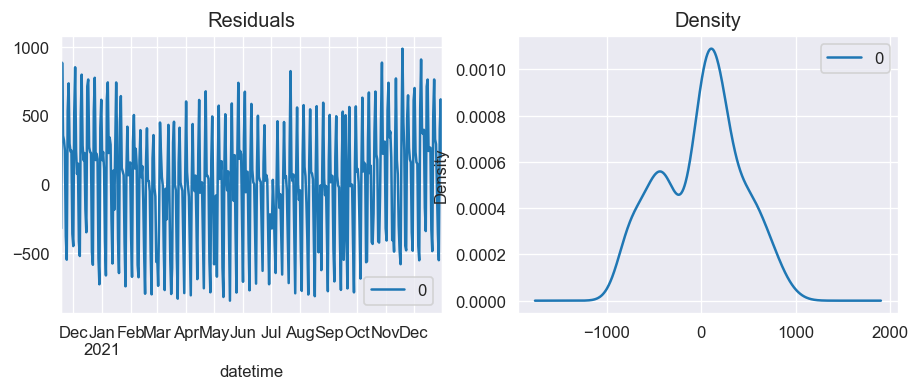

In [159]:
arima_residual_plot(result)

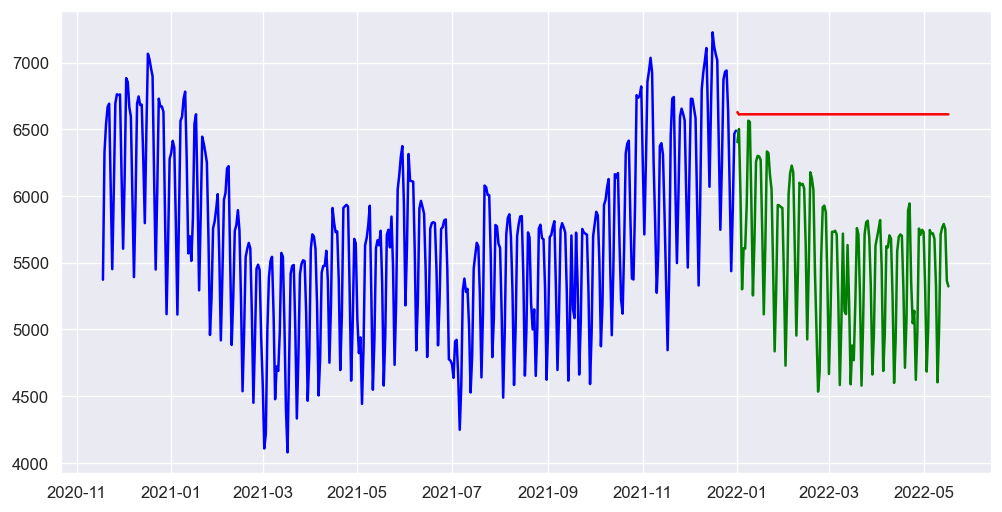

In [160]:
arima_forecast_plot(data_train, data_test, (1, 1, 1))

In [161]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:26:06   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

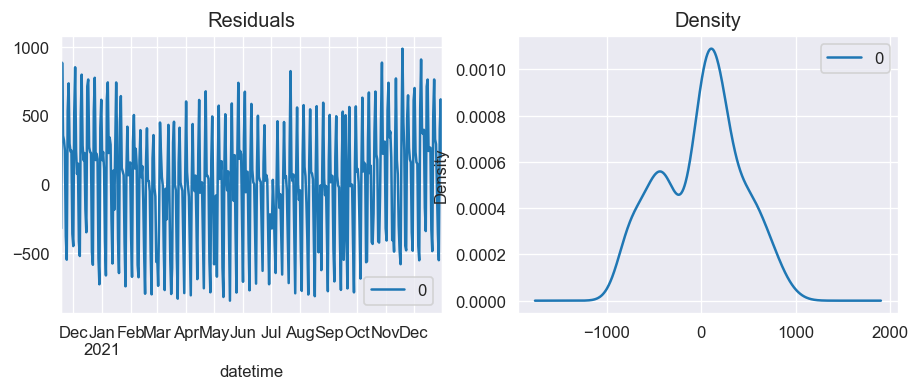

In [162]:
arima_residual_plot(result)

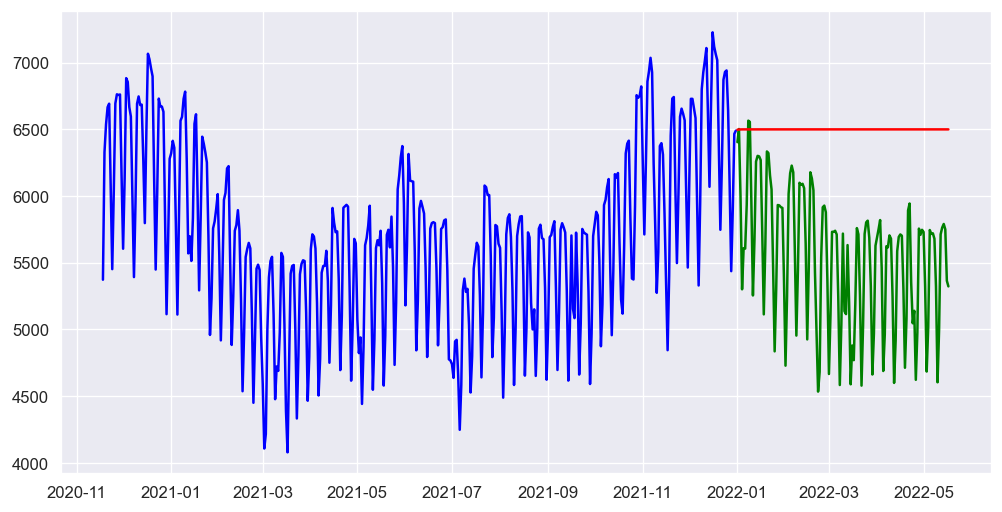

In [163]:
arima_forecast_plot(data_train, data_test, (1, 1, 0))

In [164]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:26:17   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

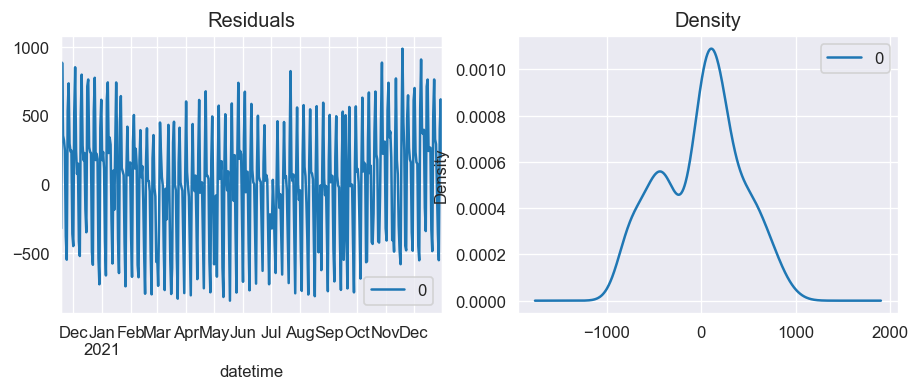

In [166]:
arima_residual_plot(result)

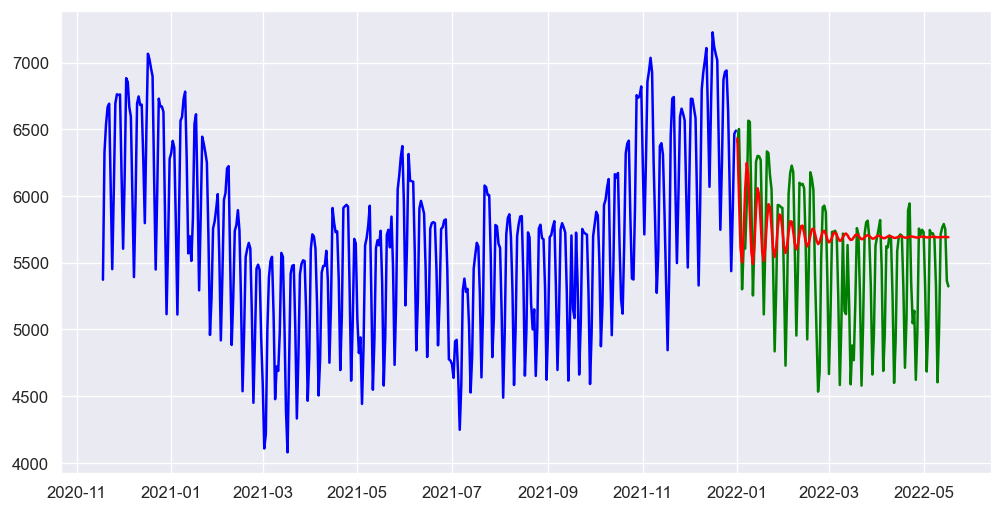

In [187]:
arima_forecast_plot(data_train, data_test, (4, 0, 3))

In [188]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                  409
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3053.395
Date:                Thu, 31 Oct 2024   AIC                           6112.790
Time:                        18:42:17   BIC                           6124.831
Sample:                    11-18-2020   HQIC                          6117.554
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5692.8107     93.542     60.858      0.000    5509.472    5876.149
ar.L1          0.7725      0.038     20.250      0.000       0.698       0.847
sigma2      1.786e+05   1.59e+04     11.238      0.0

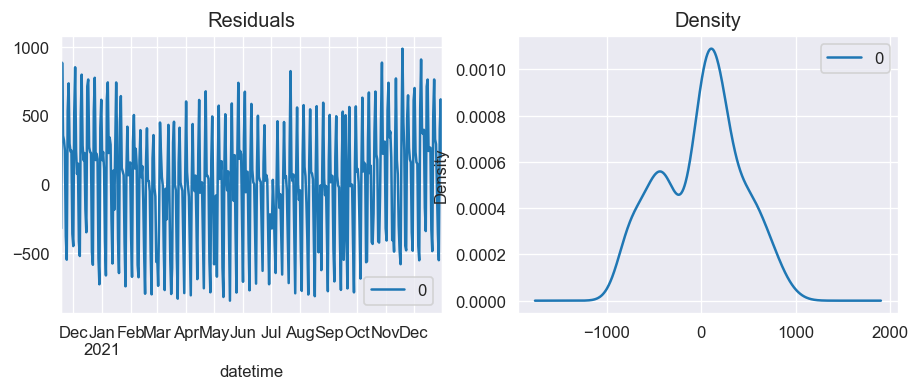

In [189]:
arima_residual_plot(result)